In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout, Activation , Concatenate, Input , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator ,img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.utils import plot_model
from keras import Model
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
!unzip 'drive/My Drive/datasets/gen.zip'


Streaming output truncated to the last 5000 lines.
  inflating: Validation/female/116633.jpg.jpg  
  inflating: Validation/female/116642.jpg.jpg  
  inflating: Validation/female/116643.jpg.jpg  
  inflating: Validation/female/116644.jpg.jpg  
  inflating: Validation/female/116645.jpg.jpg  
  inflating: Validation/female/116653.jpg.jpg  
  inflating: Validation/female/116659.jpg.jpg  
  inflating: Validation/female/116660.jpg.jpg  
  inflating: Validation/female/116666.jpg.jpg  
  inflating: Validation/female/116669.jpg.jpg  
  inflating: Validation/female/116671.jpg.jpg  
  inflating: Validation/female/116672.jpg.jpg  
  inflating: Validation/female/116674.jpg.jpg  
  inflating: Validation/female/116675.jpg.jpg  
  inflating: Validation/female/116680.jpg.jpg  
  inflating: Validation/female/116684.jpg.jpg  
  inflating: Validation/female/116686.jpg.jpg  
  inflating: Validation/female/116687.jpg.jpg  
  inflating: Validation/female/116688.jpg.jpg  
  inflating: Validation/female/116691

In [ ]:
!ls "Validation/female"


112944.jpg.jpg	113914.jpg.jpg	114839.jpg.jpg	115800.jpg.jpg	116868.jpg.jpg
112950.jpg.jpg	113915.jpg.jpg	114840.jpg.jpg	115801.jpg.jpg	116879.jpg.jpg
112953.jpg.jpg	113916.jpg.jpg	114841.jpg.jpg	115803.jpg.jpg	116884.jpg.jpg
112956.jpg.jpg	113920.jpg.jpg	114842.jpg.jpg	115811.jpg.jpg	116893.jpg.jpg
112959.jpg.jpg	113921.jpg.jpg	114844.jpg.jpg	115814.jpg.jpg	116898.jpg.jpg
112961.jpg.jpg	113922.jpg.jpg	114850.jpg.jpg	115816.jpg.jpg	116899.jpg.jpg
112967.jpg.jpg	113923.jpg.jpg	114855.jpg.jpg	115817.jpg.jpg	116906.jpg.jpg
112968.jpg.jpg	113925.jpg.jpg	114860.jpg.jpg	115819.jpg.jpg	116907.jpg.jpg
112970.jpg.jpg	113928.jpg.jpg	114861.jpg.jpg	115820.jpg.jpg	116910.jpg.jpg
112973.jpg.jpg	113930.jpg.jpg	114863.jpg.jpg	115822.jpg.jpg	116911.jpg.jpg
112974.jpg.jpg	113933.jpg.jpg	114867.jpg.jpg	115823.jpg.jpg	116915.jpg.jpg
112979.jpg.jpg	113938.jpg.jpg	114870.jpg.jpg	115824.jpg.jpg	116916.jpg.jpg
112987.jpg.jpg	113940.jpg.jpg	114871.jpg.jpg	115842.jpg.jpg	116918.jpg.jpg
112988.jpg.jpg	113950.jpg

In [ ]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# New section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir="Training"
val_dir="Validation"

train_dir_male = train_dir + '/male'
train_dir_female = train_dir + '/female'

val_dir_male  = val_dir + '/male'
val_dir_female  = val_dir + '/female'

In [ ]:
print('number of male training images - ',len(os.listdir(train_dir_male)))
print('number of female training images - ',len(os.listdir(train_dir_female)))
print('----------------------------------------------------------------------')
print('number of normal validation  images - ',len(os.listdir(val_dir_male)))
print('number of pneumonia validation  images - ',len(os.listdir(val_dir_female)))

number of male training images -  1568
number of female training images -  1544
----------------------------------------------------------------------
number of normal validation  images -  1512
number of pneumonia validation  images -  1560


In [ ]:
data_generator = ImageDataGenerator(rescale= 1./255 , validation_split=0.2)

In [ ]:
batch_size = 64

training_data = data_generator.flow_from_directory(directory = train_dir,
                                                   target_size = (64, 64),
                                                   class_mode='binary',
                                                   color_mode= "rgb",
                                                   subset='training',
                                                   batch_size = batch_size)

testing_data = data_generator.flow_from_directory(directory = train_dir,
                                                  target_size = (64, 64),
                                                  class_mode='binary',
                                                  color_mode= "rgb",
                                                  subset='validation',
                                                  batch_size = batch_size)

validation_data = data_generator.flow_from_directory(directory = val_dir,
                                                  target_size = (64, 64),
                                                  class_mode= None,
                                                  color_mode= "rgb",
                                                  batch_size = batch_size)


evaluation_generator = data_generator.flow_from_directory(directory = val_dir,
                                                  target_size = (64, 64),
                                                  class_mode= 'binary',
                                                  color_mode= "rgb",
                                                  batch_size = batch_size)

Found 2491 images belonging to 2 classes.
Found 621 images belonging to 2 classes.
Found 3072 images belonging to 2 classes.
Found 3072 images belonging to 2 classes.


In [ ]:
set(training_data.classes)

{0, 1}

In [ ]:
labels = (testing_data.class_indices)
print (labels)

{'female': 0, 'male': 1}


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=2, patience=8)

In [ ]:
input_model = Input(training_data.image_shape)


model1 = Conv2D(16,(7,7), activation='relu')(input_model)
model1 = Conv2D(32,(6,6), activation='relu', padding='same')(model1)
model1 = BatchNormalization()(model1)
model1 = MaxPooling2D((2,2))(model1)
model1 = Conv2D(32,(6,6), activation='relu' ,padding='same')(model1)
model1 = Conv2D(64,(5,5), activation='relu' ,padding='same')(model1)
model1 = BatchNormalization()(model1)
model1 = AveragePooling2D((2, 2))(model1)
model1 = Conv2D(64,(5,5), activation='relu' ,padding='same')(model1)
model1 = Conv2D(128,(5,5), activation='relu' ,padding='same')(model1)
model1 = BatchNormalization()(model1)
model1 = AveragePooling2D((2, 2))(model1)
model1 = Conv2D(256,(4,4), activation='relu' ,padding='same')(model1)
model1 = Conv2D(256,(4,4), activation='relu' ,padding='same')(model1)
model1 = BatchNormalization()(model1)
model1 = MaxPooling2D((2, 2))(model1)
model1 = Conv2D(512,(3,3), activation='relu' ,padding='same')(model1)
model1 = Conv2D(512,(3,3), activation='relu' ,padding='valid')(model1)
model1 = BatchNormalization()(model1)
model1 = Flatten()(model1)
#########################################################                          
model2 = Conv2D(16,(4,4), activation='relu')(input_model)  
model2 = Conv2D(16,(4,4), activation='relu', padding='same')(model2)
model2 = BatchNormalization()(model2)
model2 = MaxPooling2D((3, 3))(model2)
model2 = Conv2D(32,(3,3), activation='relu', padding='same')(model2) 
model2 = Conv2D(32,(3,3), activation='relu', padding='same')(model2)
model2 = BatchNormalization()(model2)
model2 = AveragePooling2D((2, 2))(model2)
model2 = Conv2D(32,(3,3), activation='relu', padding='same')(model2)
model2 = Conv2D(64,(2,2), activation='relu' ,padding='same')(model2)
model2 = BatchNormalization()(model2)
model2 = AveragePooling2D((2, 2))(model2)
model2 = Conv2D(64,(2,2), activation='relu' ,padding='same')(model2)
model2 = Conv2D(64,(2,2), activation='relu' ,padding='same')(model2)
model2 = BatchNormalization()(model2)
model2 = AveragePooling2D((2, 2))(model2)
model2 = Conv2D(128,(1,1), activation='relu' ,padding='same')(model2)
model2 = Conv2D(128,(1,1), activation='relu' ,padding='same')(model2)
model2 = BatchNormalization()(model2)
model2 = AveragePooling2D((2, 2))(model2)
model2 = Conv2D(256,(1,1), activation='relu' ,padding='same')(model2)
model2 = Conv2D(512,(1,1), activation='relu' ,padding='valid')(model2)
model2 = BatchNormalization()(model2)
model2 = Flatten()(model2)
########################################################
merged = Concatenate()([model1, model2])
merged = Dense(units = 512, activation = 'relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(rate = 0.2)(merged)
merged = Dense(units = 64, activation = 'relu')(merged)
merged = Dense(units = 32, activation = 'relu')(merged)
merged = Dense(units = 16, activation = 'relu')(merged)
merged = Dense(units = 8, activation = 'relu')(merged)
merged = Dense(units = 4, activation = 'relu')(merged)
merged = Dense(units = 2, activation = 'relu')(merged)
output = Dense(activation = 'sigmoid', units = 1)(merged)

model = Model(inputs= [input_model], outputs=[output])

In [ ]:
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 61, 61, 16)   784         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 61, 61, 16)   4112        conv2d_10[0][0]                  
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 61, 61, 16)   64          conv2d_11[0][0]                  
_______________________________________________________________________________________

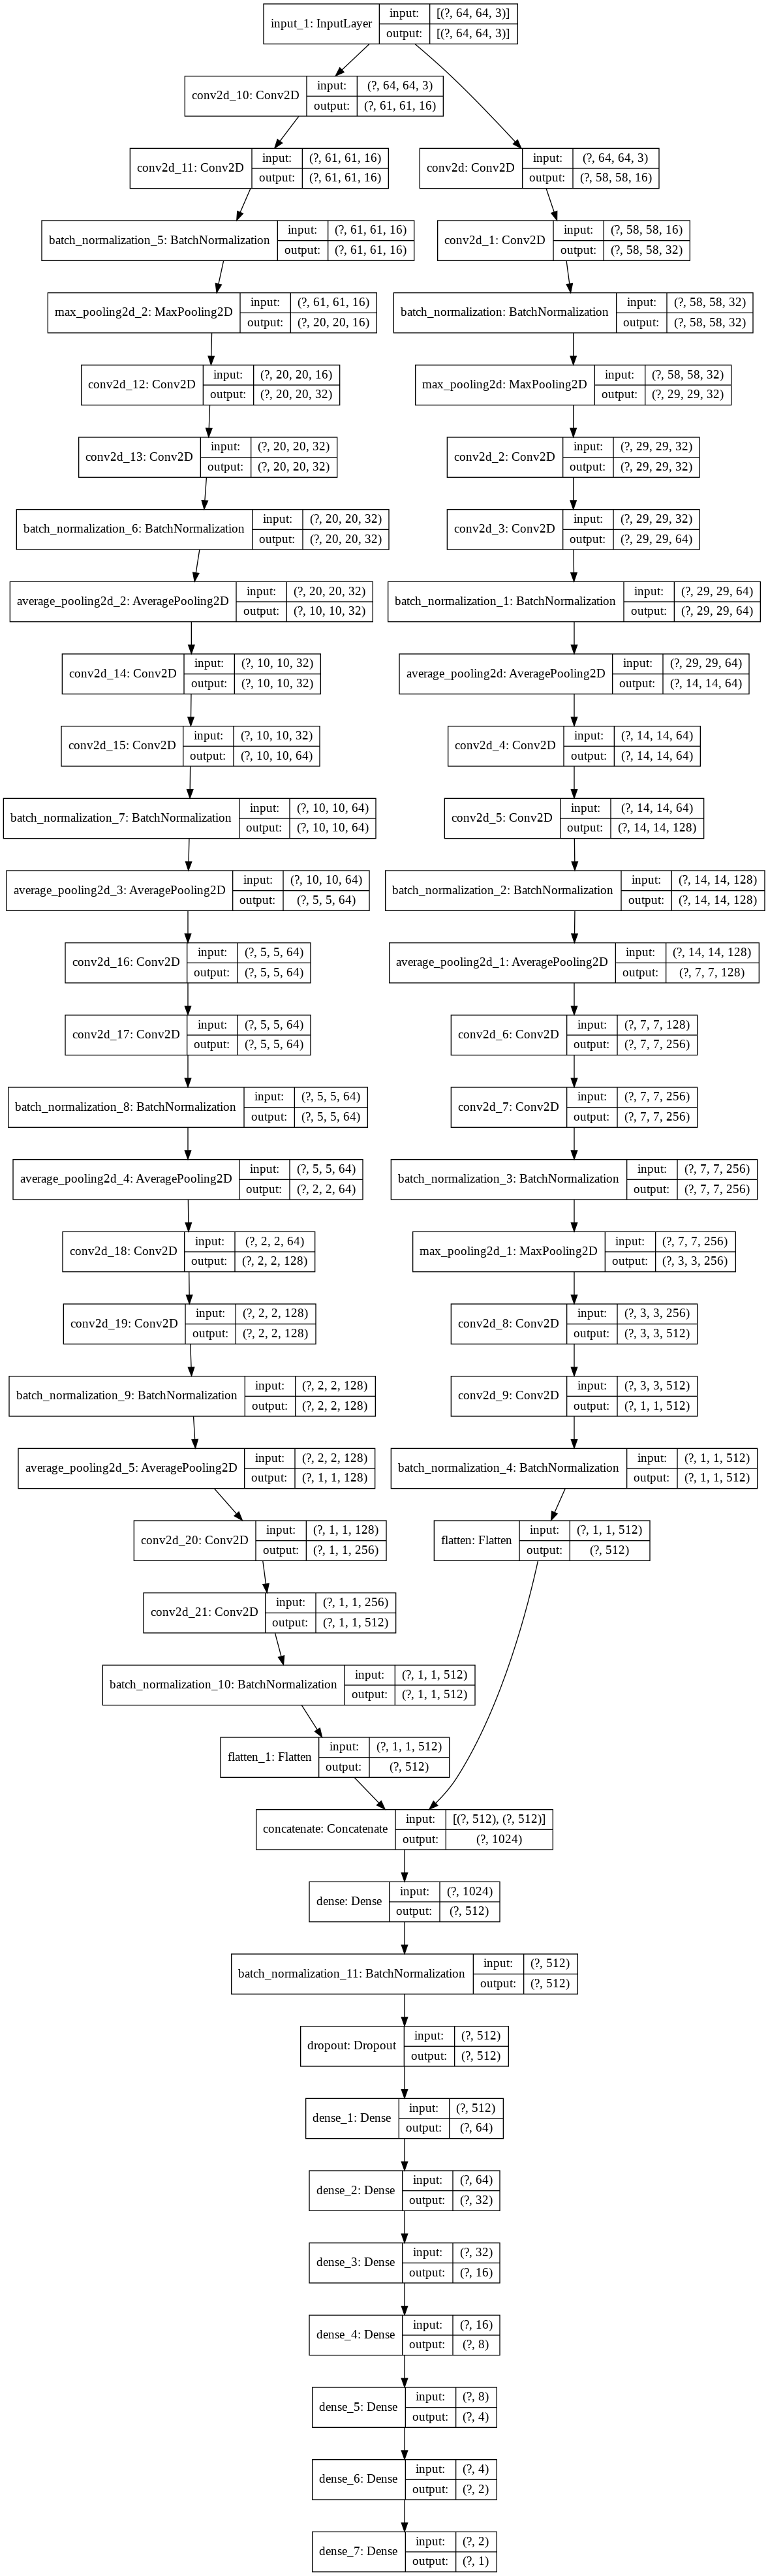

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
history =  model.fit(training_data,
                               epochs = 35,
                               #steps_per_epoch = int(len(training_data)/batch_size),
                               validation_data = testing_data ,
                               #validation_steps = int(len(testing_data)/batch_size),
                               callbacks=[es],
                               verbose=1)

Epoch 1/35
39/39 [==============================] - 165s 4s/step - loss: 0.6710 - accuracy: 0.5925 - val_loss: 0.7238 - val_accuracy: 0.5056
Epoch 2/35
39/39 [==============================] - 164s 4s/step - loss: 0.6052 - accuracy: 0.6776 - val_loss: 0.8677 - val_accuracy: 0.5040
Epoch 3/35
39/39 [==============================] - 165s 4s/step - loss: 0.5401 - accuracy: 0.7230 - val_loss: 0.6670 - val_accuracy: 0.5604
Epoch 4/35
39/39 [==============================] - 165s 4s/step - loss: 0.4590 - accuracy: 0.7764 - val_loss: 0.7728 - val_accuracy: 0.5282
Epoch 5/35
39/39 [==============================] - 165s 4s/step - loss: 0.3623 - accuracy: 0.8354 - val_loss: 0.8646 - val_accuracy: 0.5217
Epoch 6/35
39/39 [==============================] - 165s 4s/step - loss: 0.3003 - accuracy: 0.8756 - val_loss: 0.8454 - val_accuracy: 0.5072
Epoch 7/35
39/39 [==============================] - 165s 4s/step - loss: 0.2521 - accuracy: 0.8936 - val_loss: 0.7533 - val_accuracy: 0.5668
Epoch 8/35
39

In [ ]:
model.save_weights("gender_model.h5")

In [ ]:
model.predict(testing_data)

array([[6.18666410e-04],
       [2.52232780e-06],
       [7.66042113e-01],
       [9.98216510e-01],
       [9.42264259e-01],
       [9.30607985e-06],
       [4.11639718e-07],
       [7.25184407e-07],
       [2.40235352e-07],
       [1.88731829e-05],
       [9.95354772e-01],
       [1.56276001e-05],
       [5.33489674e-06],
       [9.78012323e-01],
       [9.97094035e-01],
       [9.96114075e-01],
       [2.65803601e-06],
       [3.36372286e-05],
       [1.23765567e-05],
       [3.43550859e-08],
       [9.99524236e-01],
       [9.80935931e-01],
       [4.61035961e-06],
       [6.10548022e-06],
       [8.11317563e-03],
       [1.57773495e-04],
       [9.99973893e-01],
       [4.43105307e-07],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.51164842e-01],
       [9.99413848e-01],
       [9.99999583e-01],
       [9.99999523e-01],
       [1.17576122e-03],
       [3.37072450e-08],
       [3.84449661e-02],
       [1.17634364e-07],
       [9.99990046e-01],
       [9.99794483e-01],


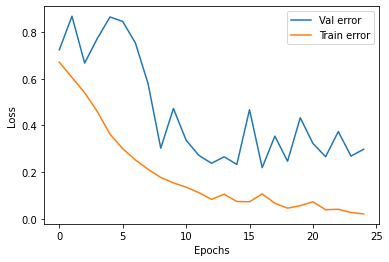

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error.png')
plt.show()

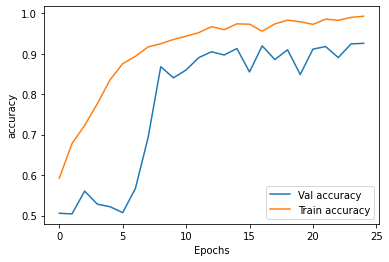

In [ ]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

plt.plot(val_accuracy)
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'], loc='lower right')
plt.savefig( 'plot_accuracy.png')
plt.show()

In [ ]:
#evaluate the model
scores = model.evaluate_generator(evaluation_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.

accuracy: 92.15%


In [ ]:
pred = model.predict_generator(validation_data)
print(pred.shape)

Instructions for updating:
Please use Model.predict, which supports generators.
(3072, 1)


In [ ]:
pred = pred.reshape(1,pred.shape[0])
predicted_class_indices= np.round_(pred)
labels = (validation_data.class_indices)
print(predicted_class_indices)
print (labels)

[[0. 0. 0. ... 0. 1. 1.]]
{'female': 0, 'male': 1}


In [ ]:
true_labels = []
perdict_labels = predicted_class_indices[0]

for i in range(len(glob.glob(val_dir_female +'/*'))):
    true_labels.append(0)
for i in range(len(glob.glob(val_dir_male +'/*'))):
    true_labels.append(1)

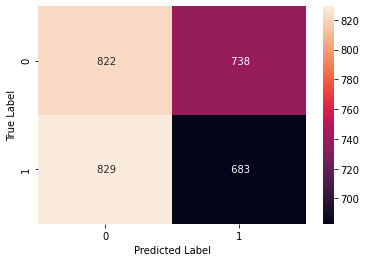

<Figure size 432x288 with 0 Axes>

In [ ]:
cm = confusion_matrix(true_labels, perdict_labels)
sns.heatmap(cm, fmt='4',annot=True).set(ylabel="True Label", xlabel="Predicted Label")
plt.show()
plt.savefig('confusion_matrix.jpg')

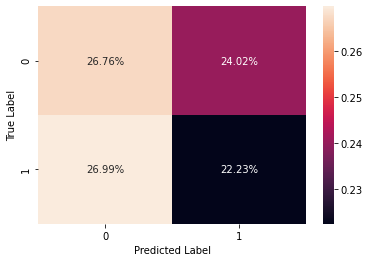

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%').set(ylabel="True Label", xlabel="Predicted Label")
plt.show()
plt.savefig('confusion_matrix_percentage.jpg')

True Label female - Perdict Label : female
{'female': 0, 'male': 1}


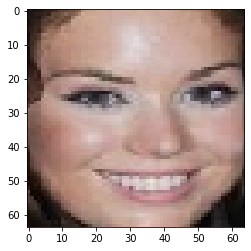

True Label female - Perdict Label : female
{'female': 0, 'male': 1}


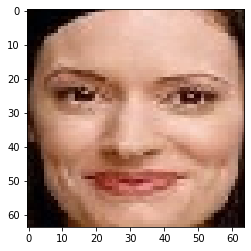

True Label female - Perdict Label : female
{'female': 0, 'male': 1}


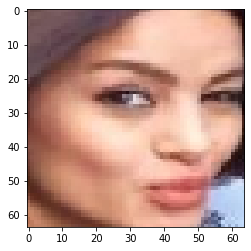

True Label female - Perdict Label : female
{'female': 0, 'male': 1}


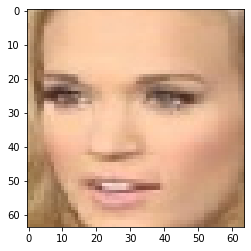

True Label female - Perdict Label : female
{'female': 0, 'male': 1}


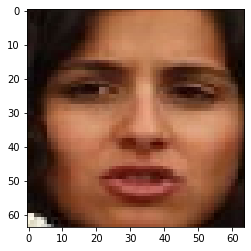

True Label female - Perdict Label : female
{'female': 0, 'male': 1}


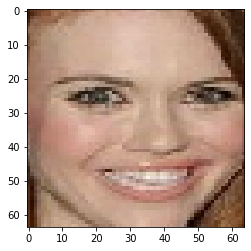

True Label female - Perdict Label : male
{'female': 0, 'male': 1}


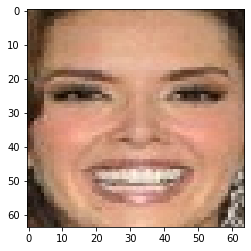

True Label female - Perdict Label : male
{'female': 0, 'male': 1}


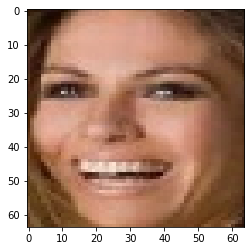

True Label female - Perdict Label : male
{'female': 0, 'male': 1}


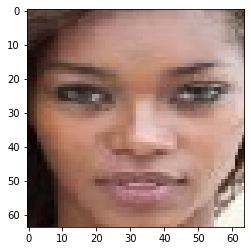

True Label female - Perdict Label : female
{'female': 0, 'male': 1}


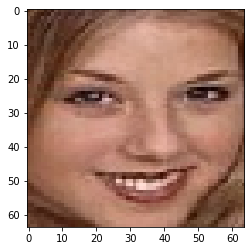

In [ ]:
paths = glob.glob(val_dir_female +'/*')
for i in range(0,10):
    test_image = image.load_img(paths[i], target_size = (64, 64))
    plt.imshow(test_image)
    if predicted_class_indices[0][i] == 0:
        pred_label = 'female'
    else:
        pred_label = 'male'
    
    print('True Label female - Perdict Label : {}'.format(pred_label))
    labels = (training_data.class_indices)
    print (labels)
    plt.show()

True Label male - Perdict Label : female
{'female': 0, 'male': 1}


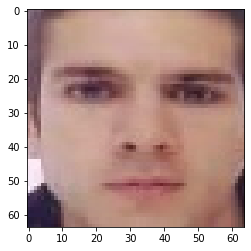

True Label male - Perdict Label : female
{'female': 0, 'male': 1}


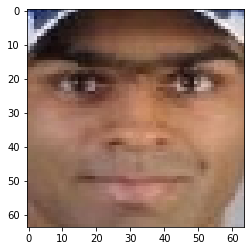

True Label male - Perdict Label : female
{'female': 0, 'male': 1}


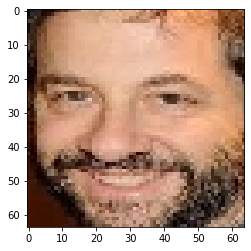

True Label male - Perdict Label : male
{'female': 0, 'male': 1}


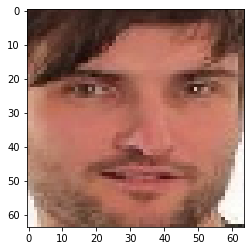

True Label male - Perdict Label : female
{'female': 0, 'male': 1}


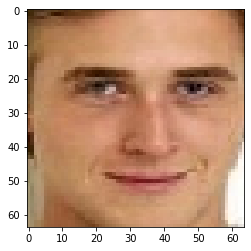

True Label male - Perdict Label : male
{'female': 0, 'male': 1}


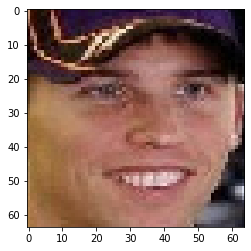

True Label male - Perdict Label : female
{'female': 0, 'male': 1}


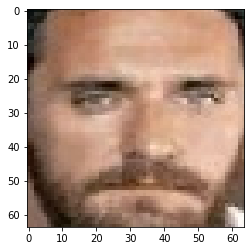

True Label male - Perdict Label : male
{'female': 0, 'male': 1}


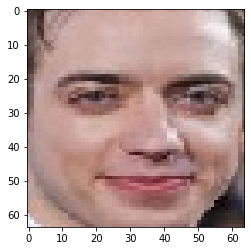

True Label male - Perdict Label : female
{'female': 0, 'male': 1}


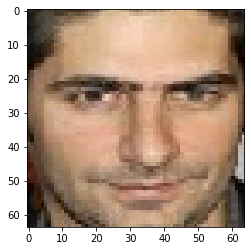

True Label male - Perdict Label : female
{'female': 0, 'male': 1}


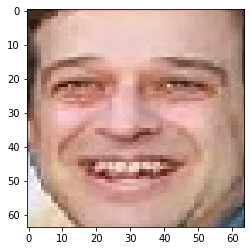

In [ ]:
paths = glob.glob(val_dir_male +'/*')
l = len(glob.glob(val_dir_female +'/*'))
for i in range(0,10):
    test_image = image.load_img(paths[i], target_size = (64, 64))
    plt.imshow(test_image)
    if predicted_class_indices[0][l+i] == 0:
        pred_label = 'female'
    else:
        pred_label = 'male'
    
    print('True Label male - Perdict Label : {}'.format(pred_label))
    labels = (training_data.class_indices)
    print (labels)
    plt.show()

In [ ]:
!pip uninstall tensorflow_estimator
!pip install tensorflow_estimator

Uninstalling tensorflow-estimator-2.3.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/tensorflow_estimator-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/*
Proceed (y/n)? 

In [ ]:

import tensorflow as tf
os.listdir(train_dir_male)
model = tf.keras.models.load_model()
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)